<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew.

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [6]:
# ANSWER
titanic_csv = '../../DATA/titanic_train.csv'
titanic = pd.read_csv(titanic_csv)

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values.

In [7]:
# ANSWER
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Impute:
- Embarked
- Age

Ignore:
- Cabin - because it is not deductable from the available data.

In [8]:
# Fill in null value based on exercise 2.2.1
titanic.loc[titanic["Embarked"].isna(),"Embarked"] = 'S'
titanic['Age'].fillna(titanic.groupby(by='Sex')['Age'].transform('median'), inplace=True)


In [9]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

### Survival VS Categorical data

In [32]:
def facetgridplot(train, var):
    '''
    KDE plot
    '''
    facet = sns.FacetGrid(train, hue="Survived", aspect=4)
    facet.map(sns.kdeplot, var, fill=True)
    facet.set(xlim=(0, train[var].max()))
    facet.add_legend()
    plt.show();

In [28]:
def bar_chart(train, feature):
    '''
    Stacked bar chart
    '''
    survived = train[train['Survived']==1][feature].value_counts(normalize=True)*100
    dead = train[train['Survived']==0][feature].value_counts(normalize=True)*100
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Not Survived']
    df.plot(kind='bar',stacked=True, figsize=(10,5)).legend(loc = 'upper right')

In [13]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


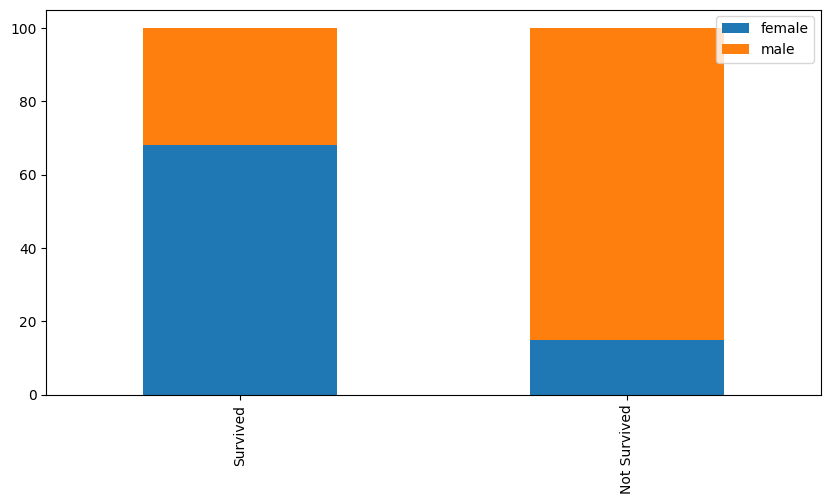

In [18]:
bar_chart(titanic,'Sex')

Differences in male and female portions in survived VS non-survived.

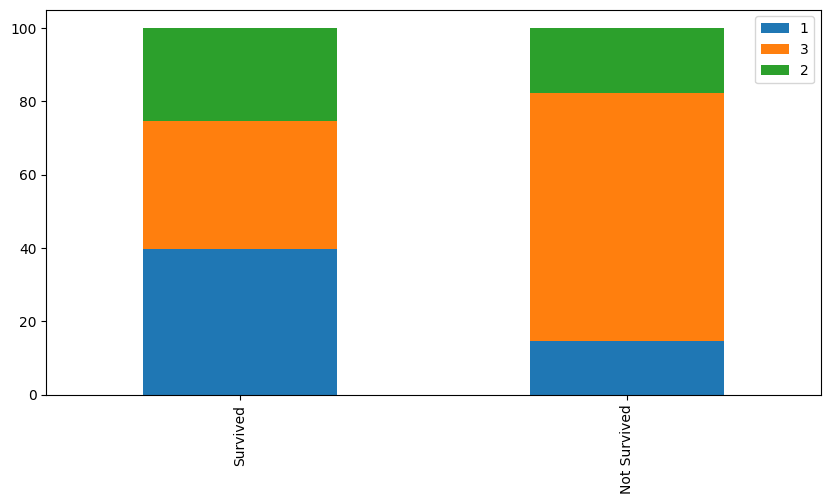

In [19]:
bar_chart(titanic,'Pclass')

Differences in Pclass portions in survived VS non-survived.

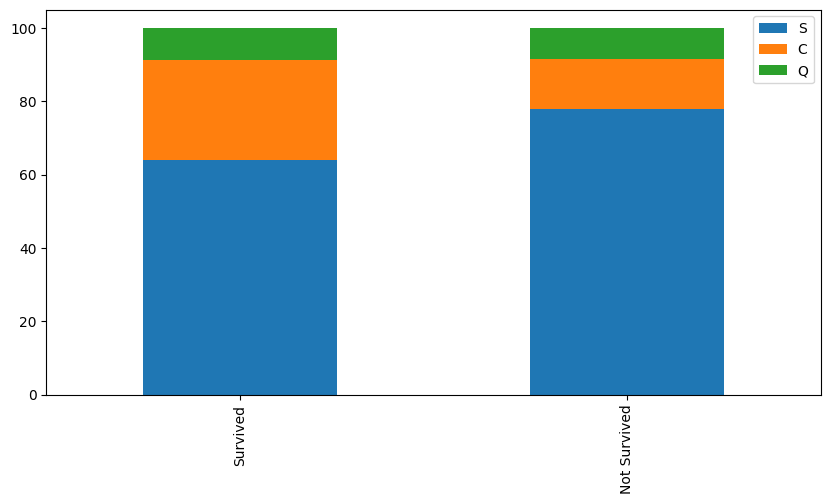

In [20]:
bar_chart(titanic,'Embarked')

Differences in embarked location portions in survived VS non-survived.

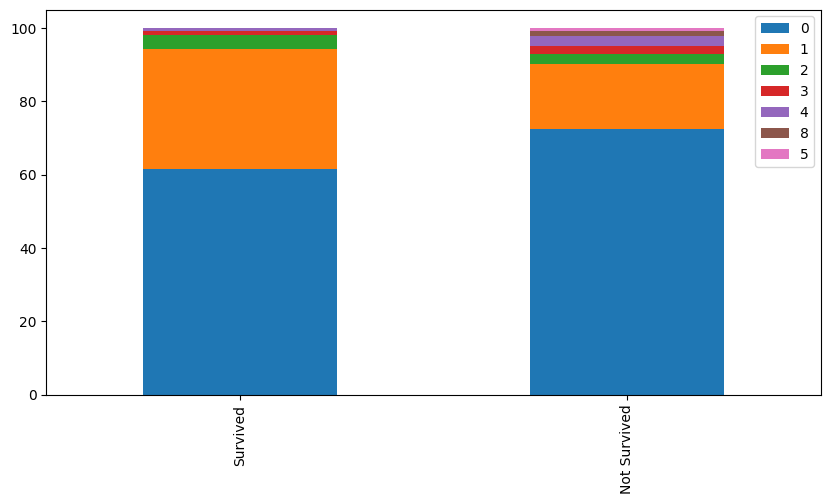

In [21]:
bar_chart(titanic, 'SibSp')

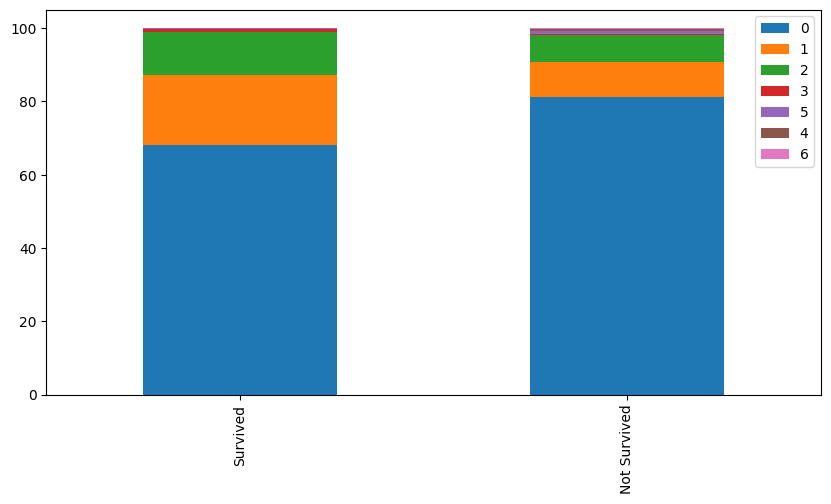

In [22]:
bar_chart(titanic, 'Parch')

Differences in proportions of passengers with different Parch and SibSp between survived and non-survived groups.

### Survival VS Numberic data

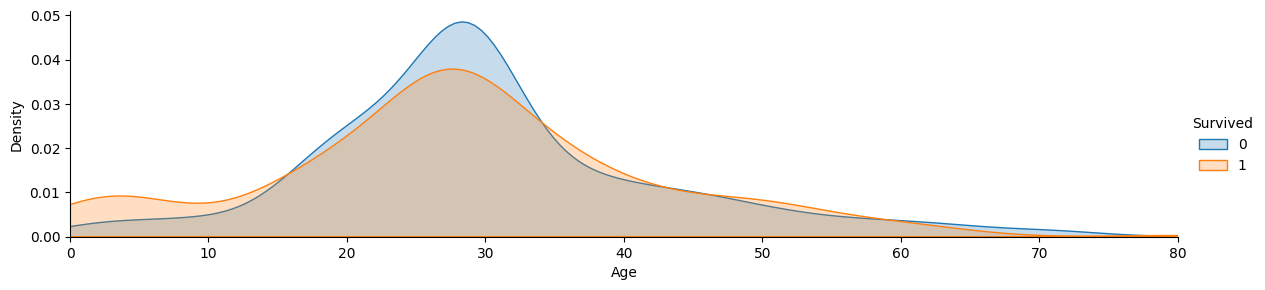

In [33]:
facetgridplot(titanic, 'Age')

Children tends to survive more than adults.
The bigger portions of adults in 20 - 35 age group did not survived. 

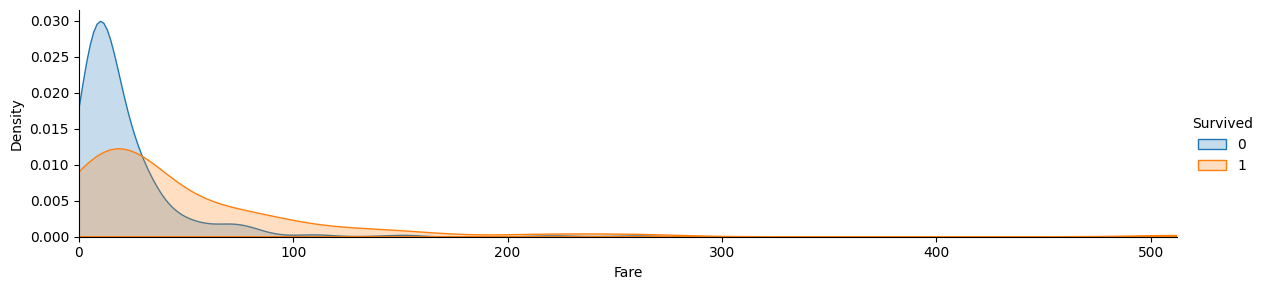

In [34]:
facetgridplot(titanic, 'Fare')

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [36]:
feature_cols = ['Pclass','Parch']
X = titanic[feature_cols]
y = titanic['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [37]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [38]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(668, 2) (668,)
(223, 2) (223,)


#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [39]:
# ANSWER
# Create Model
logreg = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [40]:
# ANSWER
# Fit Model
logreg.fit(X_train, y_train)


LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [41]:
# ANSWER
logreg.coef_

array([[-0.87239066,  0.337888  ]])

<Axes: ylabel='Feature'>

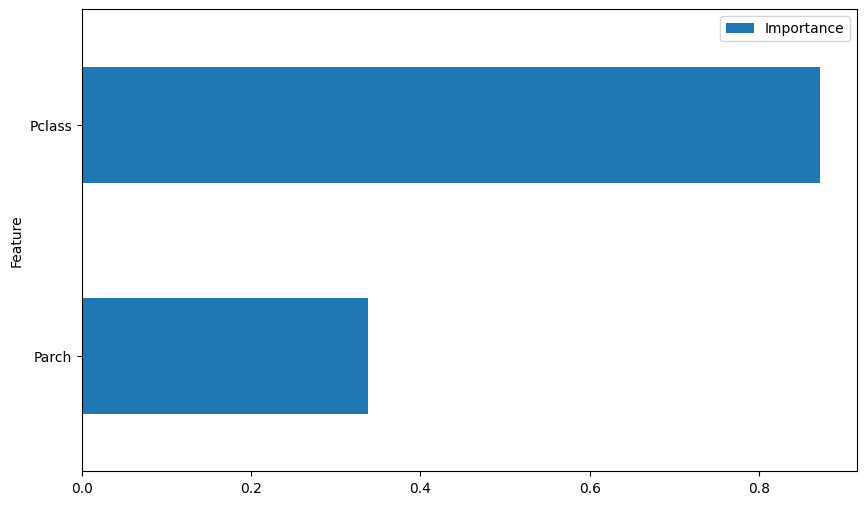

In [42]:
coefficients = logreg.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

The computed intercept (`intercept_`) is the 1st element of another array:

In [43]:
# ANSWER
logreg.intercept_

array([1.30430282])

We can create tuples of the predictor names and coefficients like this:

In [44]:
# ANSWER
print(set(zip(feature_cols, logreg.coef_[0])))

{('Parch', 0.3378880048779746), ('Pclass', -0.8723906606017777)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [45]:
for col in zip(X_train.columns, logreg.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.872391
Parch       +0.337888


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [53]:
# ANSWER
accuracy_score = logreg.score(X_train, y_train)
print('accuracy score for the training set = {:7.4f}'.format(accuracy_score))

accuracy score for the training set =  0.6901


What is the  `accuracy_score` for the test data?

In [54]:
# ANSWER
accuracy_score_testing = logreg.score(X_test, y_test)
print('accuracy score for the training set = {:7.4f}'.format(accuracy_score_testing))

accuracy score for the training set =  0.6682


What can we say about this result?

ANSWER
- The score for the training set data and the testing data is 2.19%, which is pretty low. The model is good. 
- It is not overfitting. 

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we replace `NA` values with imputed values (e.g. the overall mean age).

In [56]:
# ANSWER
feature_cols = ['Pclass', 'Parch','Age']
X = titanic[feature_cols]

In [57]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [59]:
# Build Model
logreg = LogisticRegression()

# Fit Model with the training dataset
logreg.fit(X_train,y_train)

# Score
logreg.score(X_train, y_train)

0.7200598802395209

In [60]:
# Score for the testing set
logreg.score(X_test, y_test)

0.6681614349775785

So, looking at the score from the testing set, including age did little to reduce the variance in our model. Why might this be?

ANSWER
Possibly because:
- Age is not related to Tatanic survival
- Age is not independent of other features already in the model
- Imputing the missing values distorted the distribution too much.

Let's see where the model is going wrong by showing the Confusion Matrix:

In [63]:
# ANSWER
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[106  22]
 [ 52  43]]


Nb. Here is how `confusion_matrix` arranges its output:

In [64]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: False negative (Type 2 error).

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

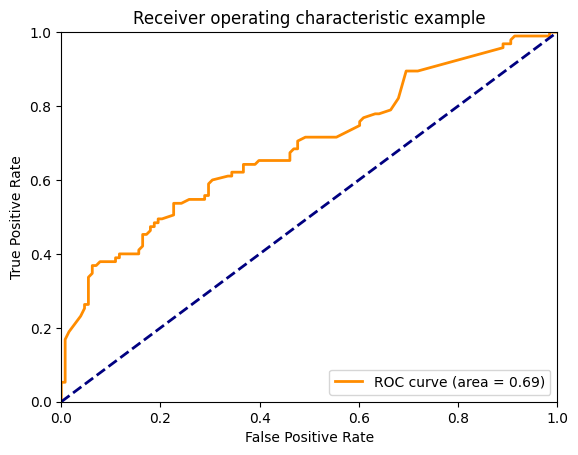

In [65]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [66]:
titanic_with_dummies = pd.get_dummies(data = titanic, columns = ['Sex', 'Embarked', 'Pclass'],
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,False,True,False,False,True,False,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,True,False,True,False,False,True,False,False
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,True,False,False,False,True,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,True,False,False,False,True,True,False,False
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,False,True,False,False,True,False,False,True


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first variable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [67]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

In [68]:
titanic_with_dummies.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.441268,0.523008,0.381594,32.204208
std,257.353842,0.486592,13.018747,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,29.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


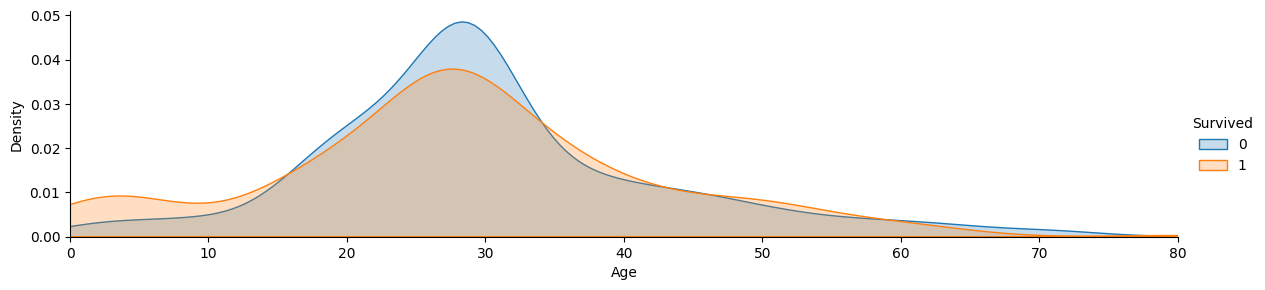

In [70]:
facetgridplot(titanic,'Age')

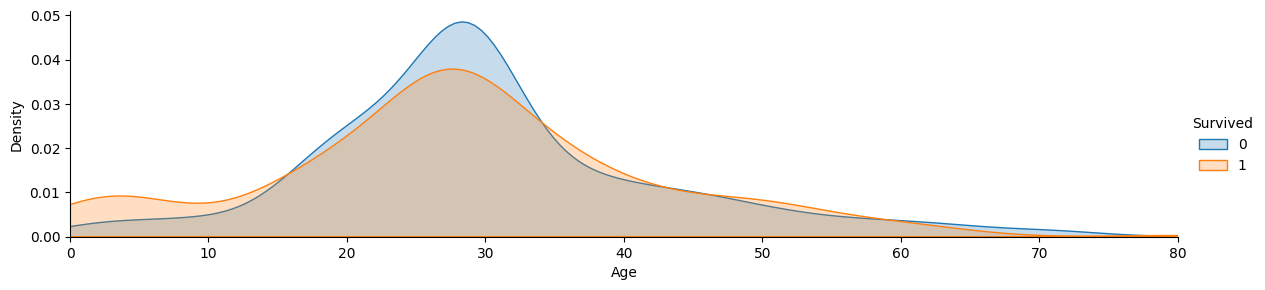

In [69]:
facetgridplot(titanic_with_dummies, 'Age')

There is no big difference between the way the age is imputed.

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [104]:
# ANSWER
# Set Feature Both Numerical, Categorical
feature_cols = ['Age','Pclass_1','Pclass_2','Sex_female','Embarked_C','Embarked_Q']
X=titanic_with_dummies[feature_cols]
y=titanic_with_dummies['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Fit the data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Score the testing set
logreg_score_test = logreg.score(X_test, y_test)

# Score the training set
logreg_score_train = logreg.score(X_train, y_train)

# Predict
logreg_preds = logreg.predict(X_test)

# Predict probability and keep the probability for positive (1)
logreg_pred_proba = logreg.predict_proba(X_test)[:1]




In [105]:
print('Accuracy score (score test): {:7.4f}'.format(logreg_score_test))
print('Score training dataset: {:7.4f}'.format(logreg_score_train))

Accuracy score (score test):  0.7892
Score training dataset:  0.8054


Plot the ROC curve for the new model:

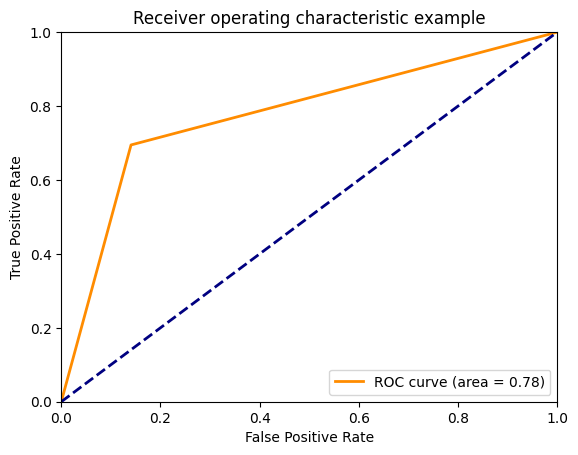

In [106]:
# ANSWER
fpr, tpr, _ =metrics.roc_curve(y_test, logreg_preds)

roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Can we improve the model by including the remaining features?

In [107]:
titanic_with_dummies.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [108]:
# ANSWER
# Use features, but EXCLUDE the features tha are dependent of each other. 
# For example, I'm using Sex_female only, but not Sex_male and Sex_female.

feature_cols = ['Age','Pclass_1','Pclass_2','Sex_female','Embarked_C','Embarked_Q','SibSp','Parch','Fare']
X=titanic_with_dummies[feature_cols]
y=titanic_with_dummies['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Fit the data
logreg_all = LogisticRegression(max_iter=200)
logreg_all.fit(X_train, y_train)

# Score the testing set
logreg_all_score_test = logreg_all.score(X_test, y_test)

# Score the training set
logreg_all_score_train = logreg_all.score(X_train, y_train)

# Predict
logreg_all_preds = logreg_all.predict(X_test)

# Predict probability and keep the probability for positive (1)
logreg_all_pred_proba = logreg_all.predict_proba(X_test)[:1]

print('Accuracy score (score test): {:7.4f}'.format(logreg_all_score_test))
print('Score training dataset: {:7.4f}'.format(logreg_all_score_train))

Accuracy score (score test):  0.7982
Score training dataset:  0.8099


In [109]:
def feature_important(logreg, feature_cols):
    coefficients = logreg.coef_[0]

    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

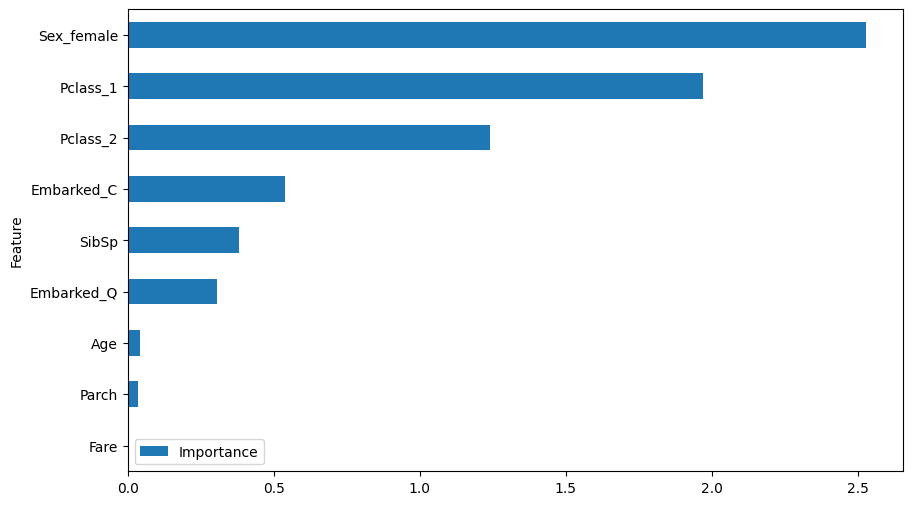

In [111]:
feature_important(logreg_all,feature_cols)

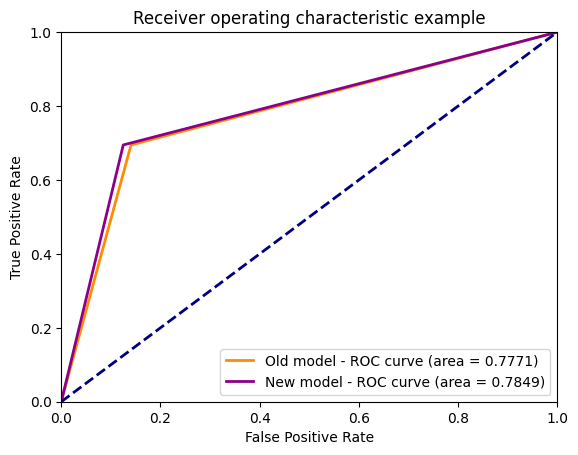

In [115]:
# Compare ROC

# New_ROC for logreg_all

fpr, tpr, _ =metrics.roc_curve(y_test, logreg_preds)
fpr_all, tpr_all, _all =metrics.roc_curve(y_test, logreg_all_preds)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_all = metrics.auc(fpr_all, tpr_all)


# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'Old model - ROC curve (area = %0.4f)' % roc_auc)
plt.plot(fpr_all, tpr_all, color='darkmagenta', lw = lw, label = 'New model - ROC curve (area = %0.4f)' % roc_auc_all)

plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Based on the ROC curve, When using all features, the model doesn't improve much. 

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

#### 1. Remove random state parameter and compare the scores.

In [133]:
def logreg_score(data, feature_cols, target_col):
    X = data[feature_cols]
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Fit the data
    logreg = LogisticRegression(max_iter=200)
    logreg.fit(X_train, y_train)

    # Score the testing set
    logreg_score_test = logreg.score(X_test, y_test)

    # Score the training set
    logreg_score_train = logreg.score(X_train, y_train)

    # Predict
    logreg_preds = logreg.predict(X_test)

    # Predict probability and keep the probability for positive (1)
    logreg_pred_proba = logreg.predict_proba(X_test)[:1]

    return logreg_score_test, logreg

In [135]:
feature_cols = ['Age','Pclass_1','Pclass_2','Sex_female','Embarked_C','Embarked_Q','SibSp','Parch','Fare']
target_col = 'Survived'

score_list = []
for i in range(5):
    score, model = logreg_score(titanic_with_dummies,feature_cols,target_col)
    print('score = {:7.4f}'.format(score))
    score_list.append(score)

np.mean(score_list)

score =  0.7803
score =  0.7758
score =  0.8251
score =  0.8206
score =  0.7892


0.7982062780269058

Yes, the score changes.

#### 2. Use Cross-validation

In [129]:
from sklearn.model_selection import cross_val_score
target_col = 'Survived'
feature_cols = ['Age','Pclass_1','Pclass_2','Sex_female','Embarked_C','Embarked_Q','SibSp','Parch','Fare']

logreg = LogisticRegression(max_iter=200)
scores = cross_val_score(logreg, titanic_with_dummies[feature_cols], titanic_with_dummies[target_col], cv=5)
scores.mean()

0.7957504237022158

#### 3. Look at the fpr and tpr vectors for the best model.

In [140]:
feature_cols = ['Age','Pclass_1','Pclass_2','Sex_female','Embarked_C','Embarked_Q','SibSp','Parch','Fare']
X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Fit the data
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)

# Score the testing set
logreg_score_test = logreg.score(X_test, y_test)

# Score the training set
logreg_score_train = logreg.score(X_train, y_train)

y_pred_class = logreg.predict(X_test)

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[118  22]
 [ 20  63]]


In [142]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       140
           1       0.74      0.76      0.75        83

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223





---



---



> > > > > > > > > © 2023 Institute of Data


---



---



